In [17]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import warnings
warnings.filterwarnings('ignore')


In [200]:
stocks = ['AAPL', 'WMT', 'GE', 'TSLA', 'AMZN', 'DB']
start_date = '2012-01-01'
end_date = '2017-01-01'

def download_data(
    stocks: list,
    start_date: str,
    end_date: str,
):
    stock_data = {}

    for stock in stocks:
        data = yf.download(stock, start = start_date, end = end_date, period='d', progress = False)['Close']
        stock_data[stock] = data
    return pd.DataFrame(stock_data)

def show_data(data):
    fig = plt.figure(figsize=(10, 7))


    for col in data.columns:
        plt.plot(data[col], label=col)
    plt.legend()
    plt.show()


def log_return(data):
    
    return np.log(data/data.shift(1))

def show_statistics(return_data):
    print(return_data.mean()*252)
    print(return_data.cov()*252)

def show_mean_statistics(rtrn_data, weights):
    portfolio_return = np.sum(rtrn_data.mean()*weights) * 252
    portfolio_vol = np.sqrt(np.dot( weights.T,np.dot(rtrn_data.cov()*252, weights))) #Weight Transpose * Covariance Matrix * Weight Vector (All dot products)
    print(f"Expected Portfolio mean: {portfolio_return}")
    print(f"Expected Portfolio Vol: {portfolio_vol}")

def generate_portfolio(rtrns):
    portfolio_mean = []
    portfolio_risk = []
    portfolio_wights = []
    NUMBER_OF_PORTS = 10000

    for i in range(1,NUMBER_OF_PORTS,1):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_wights.append(w)
        portfolio_mean.append(np.sum(rtrns.mean() * w)* 252)
        portfolio_risk.append(np.sqrt(np.dot(w.T, np.dot(rtrns.cov()*252, w))))

    return np.array(portfolio_risk), np.array(portfolio_mean), np.array(portfolio_wights)


def plot_portfolio(returns, volatilities):
    plt.figure(figsize = (10,6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid = True
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label = 'Sharpe')
    plt.show()


def statistics(weights, rtrns):
    portfolio_return = np.sum(rtrns.mean()* weights)*252
    portfolio_risks = np.sqrt(np.dot(weights.T, np.dot(rtrns.cov()*252, weights)))
    return np.array([portfolio_return, portfolio_risks, portfolio_return/portfolio_risks])

def min_function_stat(weights, rtrns):
    return -statistics(weights, rtrns)[2]


def optimize(weights, rtrns):
    contraints = {'type': 'eq', 'fun':lambda x: np.sum(x) -1}

    #Set bound
    bound = ((0,1) for _ in range(len(stocks)))
    return optimization.minimize(fun = min_function_stat, x0 = weights[0], args = rtrns, method = 'SLSQP', bounds = bound, constraints= contraints)

def print_optimal_port(optimum, returns):
    print("Optimal Portfolio: ", optimum['x'].round(4))
    print("Expected Return, Volatility, Sharpe:",
          statistics(optimum['x'].round(3), returns))


def plot_optimal_port(vol_opt, ret_opt, returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid = True
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label='Sharpe')
    plt.plot(vol_opt, ret_opt, 'g*', markersize=20)
    plt.show()


In [197]:
## DOWNLOAD NECESSARY DATA

data_dict = download_data(stocks, start_date, end_date)

## GENERATE LOG RETURNS DATA
logrtrn = log_return(data_dict)

## SHOW STATICS & GENERATE SAMPLE STATS
weights = np.array([0.2,0.2,0.2,0.1,0.1,0.2])
show_mean_statistics(logrtrn,weights)

Expected Portfolio mean: 0.09409904163668141
Expected Portfolio Vol: 0.17325820211877374


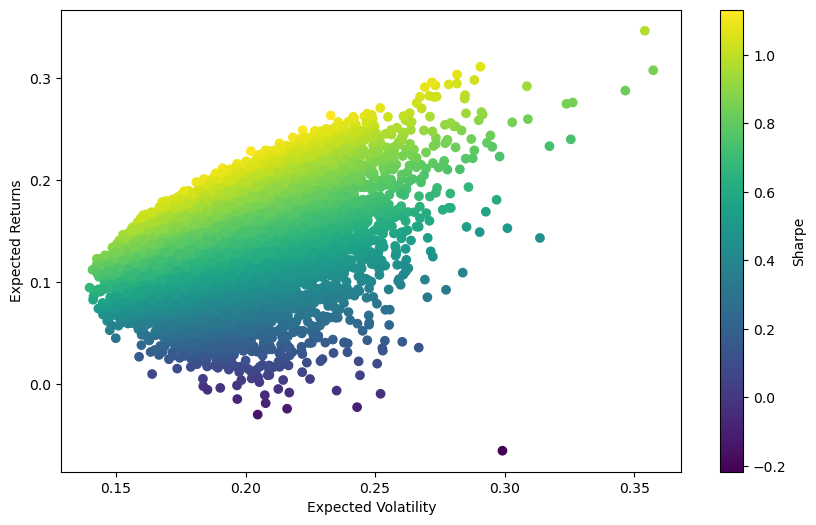

In [198]:
# GENERATE 10,000 PORTFOLIOS & PLOT THE PORTFOLIO
risks, returns, w = generate_portfolio(logrtrn)
plot_portfolio(returns, risks)

Optimal Portfolio:  [0.1425 0.     0.2251 0.2096 0.4229 0.    ]
Expected Return, Volatility, Sharpe: [0.25072316 0.22012434 1.13900695]


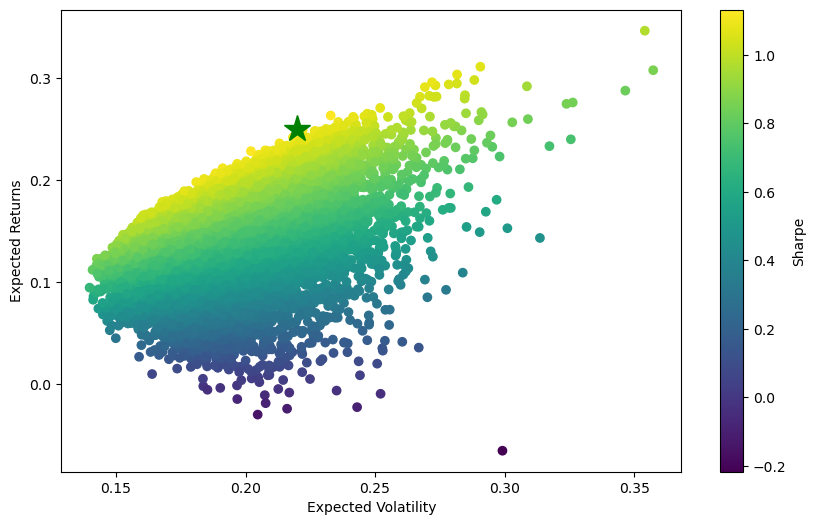

In [202]:
#FIND OPTIMUM PORTFOLIO USING SCIPY.OPTIMIZE
optimum = optimize(w, logrtrn)

#PRINT OPTIMUM VALUES & CALCULATE THE STATS OF THAT OPTIMUM VALUE
print_optimal_port(optimum, logrtrn)

#GENERATE TUPLE HOLDING THE VALUES FOR OPTIMUM SHARPE, RETURNS, & VOL
t = statistics(optimum['x'], logrtrn)

#RE-PLOT 10,000 PORTFOLIO'S BUT THIS TIME PLACE A MARKER FOR OPTIMUM VALUE
vol_opt, ret_opt  = t[1], t[0]
plot_optimal_port(vol_opt, ret_opt, returns, risks)